In [2]:
# Install and import basics
!pip install -q openpyxl seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style('whitegrid')
print('Setup complete')

Setup complete


In [3]:

from google.colab import files
uploaded = files.upload()
print('Uploaded filenames:', list(uploaded.keys()))

Saving 1730285881-Airbnb_Open_Data.xlsx to 1730285881-Airbnb_Open_Data.xlsx
Uploaded filenames: ['1730285881-Airbnb_Open_Data.xlsx']


In [5]:

FILE_PATH = '1730285881-Airbnb_Open_Data.xlsx'
df_raw = pd.read_excel(FILE_PATH)
print('Loaded rows/cols:', df_raw.shape[0], df_raw.shape[1])
df_raw.head()

Loaded rows/cols: 102599 26


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [6]:
# Lowercase and snake_case to avoid typos later
df = df_raw.copy()
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('/', '_')
)
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [7]:


clean = df.copy()

clean = clean.drop_duplicates()

for c in ['house_rules', 'license']:
    if c in clean.columns:
        clean = clean.drop(columns=[c])

for c in ['price', 'service_fee']:
    if c in clean.columns:
        clean[c] = clean[c].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
        clean[c] = pd.to_numeric(clean[c], errors='coerce')

rename_map = {}
if 'price' in clean.columns:
    rename_map['price'] = 'price_$'
if 'service_fee' in clean.columns:
    rename_map['service_fee'] = 'service_fee_$'
clean = clean.rename(columns=rename_map)


if 'neighbourhood_group' in clean.columns:
    clean['neighbourhood_group'] = clean['neighbourhood_group'].replace({'brookin':'Brooklyn','BROOKIN':'Brooklyn'})

if 'availability_365' in clean.columns:
    clean['availability_365'] = pd.to_numeric(clean['availability_365'], errors='coerce')
    clean['availability_365'] = clean['availability_365'].clip(lower=0, upper=365)
    q1 = clean['availability_365'].quantile(0.25)
    q3 = clean['availability_365'].quantile(0.75)
    iqr = q3 - q1
    lower = max(0, q1 - 1.5*iqr)
    upper = min(365, q3 + 1.5*iqr)
    clean = clean[(clean['availability_365'] >= lower) & (clean['availability_365'] <= upper)]


clean = clean.dropna()


int_candidates = ['calculated_host_listings_count','minimum_nights','number_of_reviews','review_rate_number','availability_365','construction_year']
for c in int_candidates:
    if c in clean.columns:
        clean[c] = pd.to_numeric(clean[c], errors='coerce').astype('int64')

if 'instant_bookable' in clean.columns:

    clean['instant_bookable'] = clean['instant_bookable'].astype(str).str.strip().str.lower().map({'true': True, 'false': False, '1': True, '0': False})
    clean['instant_bookable'] = clean['instant_bookable'].fillna(False)

print('Cleaning complete. Shape:', clean.shape)
clean.head()

Cleaning complete. Shape: (83390, 24)


/tmp/ipython-input-53257162.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean['instant_bookable'] = clean['instant_bookable'].fillna(False)


,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,construction_year,price_$,service_fee_$,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,2020,966.0,193.0,10,9,2021-10-19,0.21,4,6,286
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,2007,142.0,28.0,30,45,2022-05-21,0.38,4,2,228
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,2009,204.0,41.0,10,9,2018-11-19,0.10,3,1,289
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,2013,577.0,115.0,3,74,2019-06-22,0.59,3,1,365
7,1005202,BlissArtsSpace!,90821839709,unconfirmed,Emma,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,United States,...,2009,1060.0,212.0,45,49,2017-10-05,0.40,5,1,219


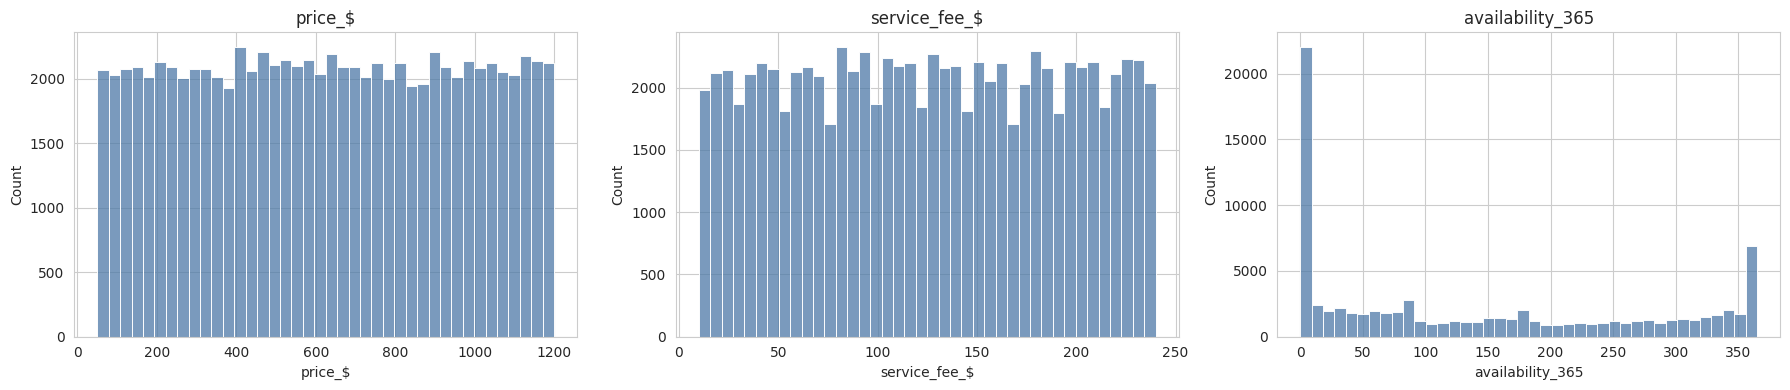

QA plots displayed


In [8]:

cols_plot = [c for c in ['price_$', 'service_fee_$', 'availability_365'] if c in clean.columns]
n = len(cols_plot)
if n > 0:
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    if n == 1:
        axes = [axes]
    for ax, c in zip(axes, cols_plot):
        sns.histplot(clean[c], bins=40, color='#4e79a7', ax=ax)
        ax.set_title(c)
    plt.tight_layout()
    plt.show()
print('QA plots displayed')

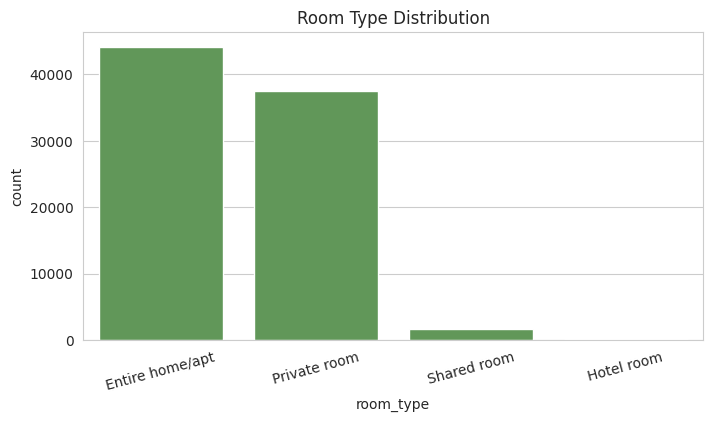

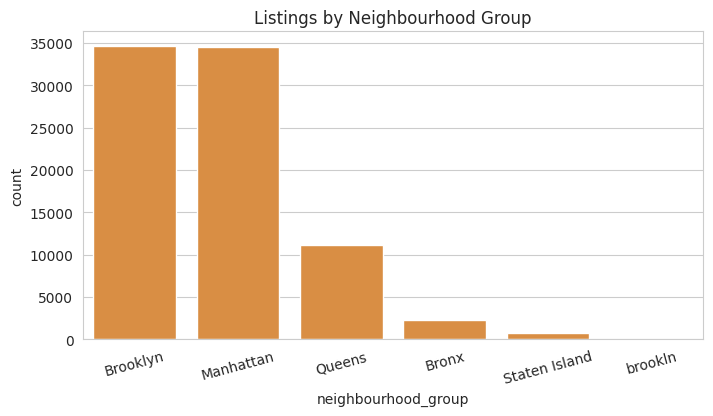

Basic counts done


In [9]:
if 'room_type' in clean.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=clean, x='room_type', order=clean['room_type'].value_counts().index, color='#59a14f')
    plt.title('Room Type Distribution')
    plt.xticks(rotation=15)
    plt.show()

if 'neighbourhood_group' in clean.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=clean, x='neighbourhood_group', order=clean['neighbourhood_group'].value_counts().index, color='#f28e2b')
    plt.title('Listings by Neighbourhood Group')
    plt.xticks(rotation=15)
    plt.show()
print('Basic counts done')

  neighbourhood_group     price_$
3              Queens  630.502517
0               Bronx  630.201147
1            Brooklyn  627.435632
2           Manhattan  623.451839
4       Staten Island  622.132353


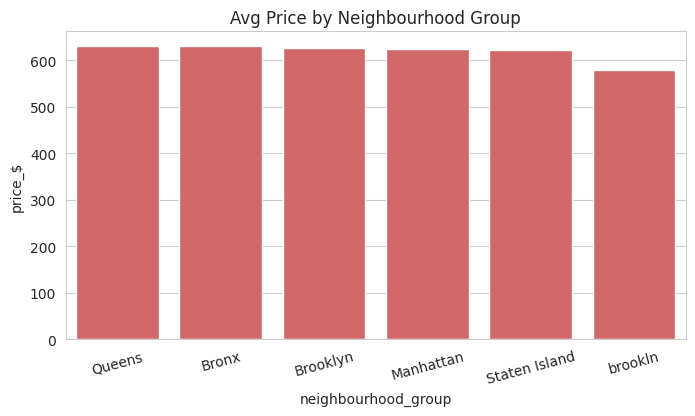

         room_type     price_$
1       Hotel room  657.953704
3      Shared room  629.996962
2     Private room  627.730426
0  Entire home/apt  624.713102


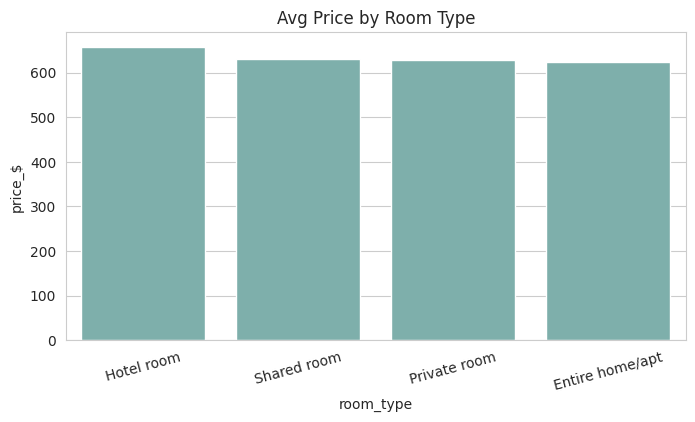

Avg price charts done


In [10]:
if 'price_$' in clean.columns and 'neighbourhood_group' in clean.columns:
    gp = clean.groupby('neighbourhood_group', as_index=False)['price_$'].mean().sort_values('price_$', ascending=False)
    print(gp.head())
    plt.figure(figsize=(8,4))
    sns.barplot(data=gp, x='neighbourhood_group', y='price_$', color='#e15759')
    plt.title('Avg Price by Neighbourhood Group')
    plt.xticks(rotation=15)
    plt.show()

if 'price_$' in clean.columns and 'room_type' in clean.columns:
    gr = clean.groupby('room_type', as_index=False)['price_$'].mean().sort_values('price_$', ascending=False)
    print(gr.head())
    plt.figure(figsize=(8,4))
    sns.barplot(data=gr, x='room_type', y='price_$', color='#76b7b2')
    plt.title('Avg Price by Room Type')
    plt.xticks(rotation=15)
    plt.show()
print('Avg price charts done')

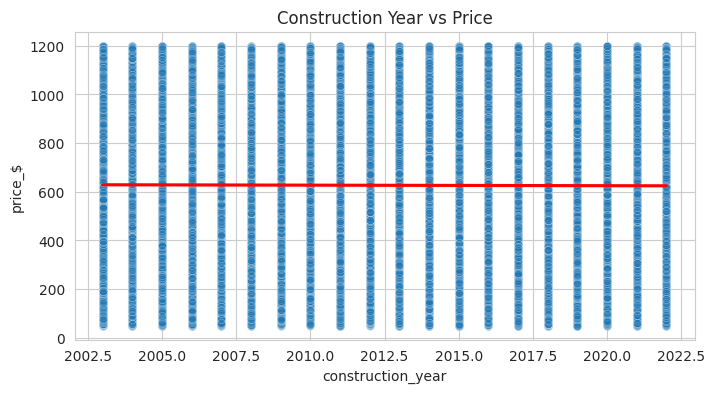

Construction year plot done


In [11]:
if 'construction_year' in clean.columns and 'price_$' in clean.columns:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=clean, x='construction_year', y='price_$', alpha=0.3)
    sns.regplot(data=clean, x='construction_year', y='price_$', scatter=False, color='red')
    plt.title('Construction Year vs Price')
    plt.show()
print('Construction year plot done')

           host_id  calculated_host_listings_count
9133   10572530839                             332
52414  61907398658                             332
57191  67585934289                             332
17081  20052088242                             332
27059  31759913186                             332
22221  26125388039                             332
70513  83412943157                             332
70850  83842788941                             332
17369  20383154439                             332
49580  58398584635                             332


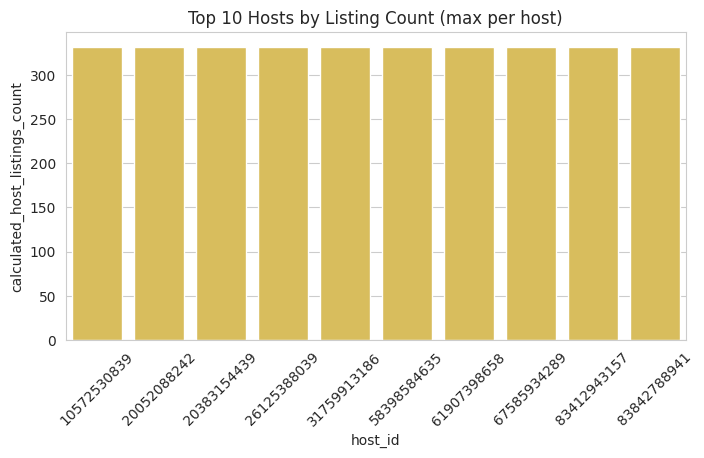

Top hosts done


In [13]:

if 'host_id' in clean.columns and 'calculated_host_listings_count' in clean.columns:
    top_hosts = (clean.groupby(['host_id'], as_index=False)['calculated_host_listings_count']
                 .max()
                 .sort_values('calculated_host_listings_count', ascending=False)
                 .head(10))
    print(top_hosts)
    plt.figure(figsize=(8,4))
    sns.barplot(data=top_hosts, x='host_id', y='calculated_host_listings_count', color='#edc948')
    plt.title('Top 10 Hosts by Listing Count (max per host)')
    plt.xticks(rotation=45)
    plt.show()
print('Top hosts done')

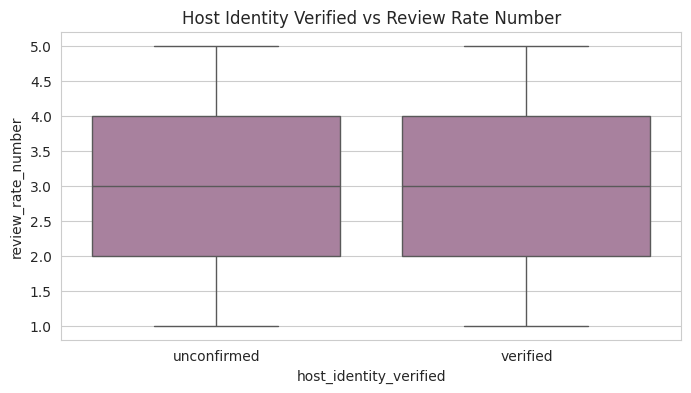

Verification vs review rate done


In [14]:
if 'host_identity_verified' in clean.columns and 'review_rate_number' in clean.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=clean, x='host_identity_verified', y='review_rate_number', color='#af7aa1')
    plt.title('Host Identity Verified vs Review Rate Number')
    plt.show()
print('Verification vs review rate done')

Correlation (price_$, service_fee_$): 0.9999909085489863


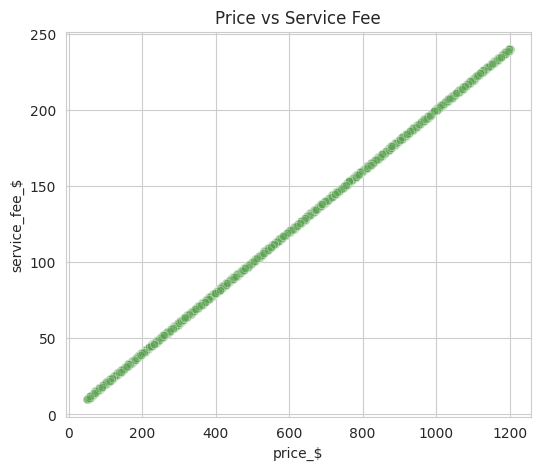

Price vs service fee correlation done


In [15]:
if 'price_$' in clean.columns and 'service_fee_$' in clean.columns:
    corr_val = clean[['price_$','service_fee_$']].corr().iloc[0,1]
    print('Correlation (price_$, service_fee_$):', corr_val)
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=clean, x='price_$', y='service_fee_$', alpha=0.3, color='#59a14f')
    plt.title('Price vs Service Fee')
    plt.show()
print('Price vs service fee correlation done')

Overall average review_rate_number: 3.2787144741575727
  neighbourhood_group  review_rate_number
5             brookln            4.000000
4       Staten Island            3.415441
0               Bronx            3.337009
3              Queens            3.327041
2           Manhattan            3.275686


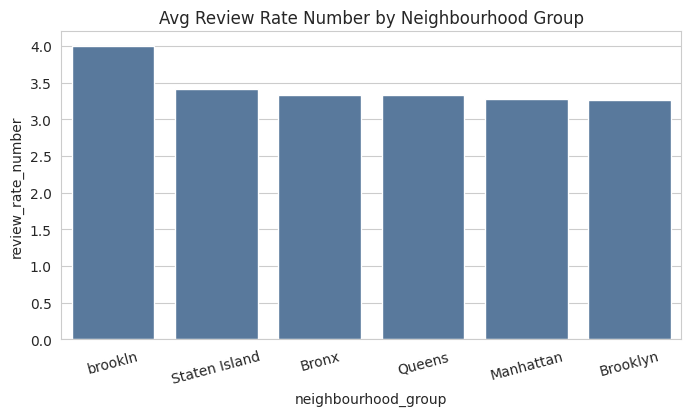

Review averages done


In [16]:
if 'review_rate_number' in clean.columns:
    overall_avg = clean['review_rate_number'].mean()
    print('Overall average review_rate_number:', overall_avg)
if 'review_rate_number' in clean.columns and 'neighbourhood_group' in clean.columns:
    by_ng = clean.groupby('neighbourhood_group', as_index=False)['review_rate_number'].mean().sort_values('review_rate_number', ascending=False)
    print(by_ng.head())
    plt.figure(figsize=(8,4))
    sns.barplot(data=by_ng, x='neighbourhood_group', y='review_rate_number', color='#4e79a7')
    plt.title('Avg Review Rate Number by Neighbourhood Group')
    plt.xticks(rotation=15)
    plt.show()
print('Review averages done')

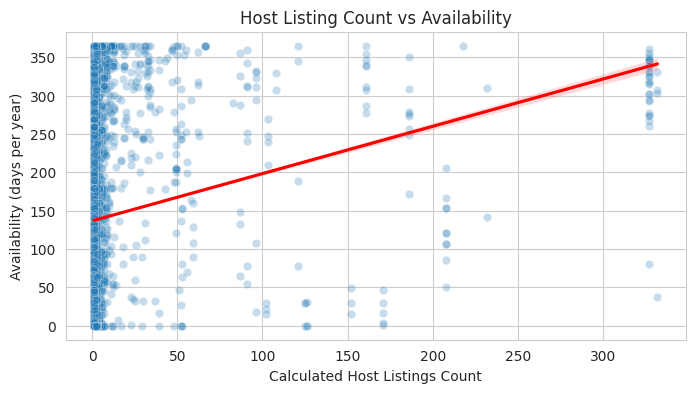

Host vs availability done


In [17]:
if 'calculated_host_listings_count' in clean.columns and 'availability_365' in clean.columns:
    plt.figure(figsize=(8,4))
    sns.scatterplot(
        data=clean.sample(min(5000, len(clean)), random_state=42),
        x='calculated_host_listings_count',
        y='availability_365',
        alpha=0.25
    )
    sns.regplot(
        data=clean,
        x='calculated_host_listings_count',
        y='availability_365',
        scatter=False,
        color='red'
    )
    plt.title('Host Listing Count vs Availability')
    plt.xlabel('Calculated Host Listings Count')
    plt.ylabel('Availability (days per year)')
    plt.show()
print('Host vs availability done')

In [18]:
out_path = 'airbnb_cleaned.csv'
clean.to_csv(out_path, index=False)
print('Saved cleaned data to:', out_path)

Saved cleaned data to: airbnb_cleaned.csv
